# Feature Selection
- is there a correlation between categories?
    - chisqu
    - mutual information?
- is there a correlation between continuous and categorical variables?
    - kruskal wallis?
- is there a correlation between continuous variables
    - pearson/spearman

In [2]:
%load_ext autoreload
%autoreload 2

In [422]:
import pandas as pd
from preprocessing import load_if_in_country_or_lang
from preprocessing import categorize_views_for_df
from processing import filter_by_region_cat_code, build_regression_dataframe, load_preprocessed_events
from plot_regression import plot_heatmap_and_clustermap, plot_regression_results_from_dict, plot_regression_results_interactions_from_dict, plot_cat_by_cat_variable
import numpy as np
from regression import fit_nb_with_estimated_alpha, estimate_alpha, fit_nb, standardize_var, fit_nb_with_estimated_alpha_all_codes, standardize_var

In [4]:
df_crawled = pd.read_csv('events/new/processed_0_manually_with_wikiviews.csv').drop_duplicates()

In [5]:
df_crawled[df_crawled.cat == 'undefined'].head()

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Country/Area,Year,GDP_pc,GDP,oecd,in_code_lang,in_code_region,date_month,views_baseline,view_country_article
200,Q107353229,Chinese elephants expedition,2020-03-01,Global South,China,Asia,undefined,"['Category:2021 in China', 'Category:Animal mi...",0,0.000000,...,China,2020.0,10228.970558,1.472280e+13,False,False,False,2020-03-01,1.842000e+06,20676.5
214,Q109110309,Wikipedia:Meetup/Johor 9,2019-05-01,Global South,Malaysia,Asia,undefined,"['Category:Wikipedia meetups in Malaysia', 'Ca...",0,0.000000,...,Malaysia,2019.0,11414.290367,3.646840e+11,False,False,False,2019-05-01,5.815000e+07,9350.0
245,Q138837,Catalan Republic (2017),2017-10-27,Global North,Spain,Europe,undefined,['Category:Redirects connected to a Wikidata i...,392630,0.000000,...,Spain,2017.0,28137.441564,1.312539e+12,True,False,False,2017-10-01,4.312950e+07,11320.0
247,Q1437630,"Solar eclipse of August 21, 2017",2017-08-21,Global North,United States,North America,undefined,"['Category:2017 in science', 'Category:2017 in...",1244878,157979.285714,...,United States,2017.0,59921.674703,1.947962e+13,True,True,True,2017-08-01,3.217767e+09,44815.0
1014,Q22081742,Wikipedia:Meetup/justfortherecord/Events/heroines,2016-01-15,Global North,Belgium,Europe,undefined,[],0,0.000000,...,Belgium,2016.0,41899.065629,4.757396e+11,True,False,False,2016-01-01,2.536950e+07,8722.0


In [532]:
df_crawled.columns

Index(['event_id', 'pagetitle', 'event_date', 'economic_region', 'country',
       'continent', 'cat', 'categories', 'views_7_sum', 'views_before_mean',
       'views_before_sum', 'views_before_max', 'views_before_min',
       'views_before_median', 'views_before_increase', 'list_views_7_days',
       'diff_days', 'year', 'planed', 'surprising', 'factor', 'page_creation',
       'edits_7_sum', 'edits_before_min', 'edits_before_mean',
       'edits_before_max', 'edits_before_median', 'edits_before_sum', 'code',
       'bing_hits', 'gni_class', 'gni_region', 'population', 'Country/Area',
       'Year', 'GDP_pc', 'GDP', 'oecd', 'in_code_lang', 'in_code_region',
       'date_month', 'views_baseline', 'view_country_article',
       'country_articles', 'country_articles_log', 'cat_articles',
       'cat_articles_log', 'country_cat_articles', 'country_cat_articles_log',
       'planned'],
      dtype='object')

In [6]:
df_crawled = df_crawled[df_crawled.cat != 'undefined']
df_crawled = df_crawled.drop_duplicates()
df_crawled[df_crawled.pagetitle.duplicated(keep=False)]

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Country/Area,Year,GDP_pc,GDP,oecd,in_code_lang,in_code_region,date_month,views_baseline,view_country_article


In [7]:
from processing import calculate_uniqueness, calculate_uniqueness_two_columns

# how should uniqueness decay?
df_crawled.event_date = pd.to_datetime(df_crawled.event_date)
df_crawled = calculate_uniqueness(df_crawled, 30, 'country')
df_crawled = calculate_uniqueness(df_crawled, 30, 'cat')
df_crawled = calculate_uniqueness_two_columns(df_crawled, 30, 'country', 'cat')

# MRMR

In [548]:
from regression import transform_vars_for_regression, compute_mrmr_for_code
df_crawled['planned'] = df_crawled.planed == 'planed'
df_crawled['surprised'] = df_crawled.surprising == 'surprising'
df_reg = df_crawled[(df_crawled.cat != 'undefined') & (df_crawled.event_date.dt.year >= 2016) & (df_crawled.views_7_sum > 10)].copy()
df_reg = transform_vars_for_regression(df_reg)

In [553]:
from mrmr import mrmr_classif
list_coefs = ['code', 'in_code_lang', 'cat', 'planned', 'surprised', 'gni_region', 'continent', 'views_baseline_log', 'population_log', 'view_country_article_log', 'country_articles_log', 'cat_articles_log', 'country_cat_articles_log', 'gni_class', 'GDP_pc_log', 'economic_region', 'oecd']
list_coefs_numerical = ['views_baseline_log', 'population_log',  'view_country_article_log', 'country_articles_log', 'cat_articles_log', 'country_cat_articles_log', 'GDP_pc_z', 'gni_class_ranked']
list_coefs_cat = ['code', 'cat',  'planned', 'gni_region', 'gni_class', 'economic_region', 'oecd', 'continent', 'surprised', 'in_code_lang']

df_mrmr, red_matrices = compute_mrmr_for_code(df_reg, list_coefs, list_coefs_cat, red_func='pearson')
df_mrmr_sm, red_matrices_sm = compute_mrmr_for_code(df_reg, list_coefs, list_coefs_cat, red_func='spearman')

In [556]:
df_mrmr

all                                  de            \
                      column       rel                    column       rel   
0                        cat  1.293005                       cat  1.234990   
1             population_log  1.318584                gni_region  3.189857   
2                       oecd  1.414355                 surprised  0.935381   
3                       code  0.922452            population_log  0.956077   
4                  surprised  0.654132              in_code_lang  0.863282   
5               in_code_lang  1.353220          cat_articles_log  1.014492   
6                  gni_class  1.225305                   planned  1.345912   
7   country_cat_articles_log  1.151848                      oecd  1.264023   
8                 GDP_pc_log  0.996945  view_country_article_log  1.364564   
9                    planned  1.175232                GDP_pc_log  0.931721   
10                 continent  1.230653  country_cat_articles_log  2.082651   
11          cat_articles_log  1.154240                 continent  0.901544   
12           economic_region  1.093868        views_baseline_log  0.994829   
13                gni_region  1.044167                 gni_class  1.191736   
14      country_articles_log  1.184028      country_articles_log  0.899328   
15  view_country_article_log  1.041269           economic_region  1.101588   
16        views_baseline_log  1.091063                       NaN       NaN   

                          en                                  es            \
                      column       rel                    column       rel   
0   country_cat_articles_log  1.124100                       cat  1.186901   
1                  gni_class  1.494964        views_baseline_log  1.394117   
2                  surprised  0.828515                 surprised  0.940231   
3               in_code_lang  0.729227                 gni_class  0.862642   
4                        cat  1.117438          cat_articles_log  1.205268   
5            economic_region  1.022447                   planned  1.229169   
6             population_log  1.191783                gni_region  1.009059   
7           cat_articles_log  1.014556                      oecd  0.833284   
8                       oecd  1.193874              in_code_lang  0.984436   
9       country_articles_log  1.447088      country_articles_log  0.859827   
10                   planned  1.119523            population_log  1.099919   
11                gni_region  1.507002                GDP_pc_log  0.841053   
12                GDP_pc_log  1.366736                 continent  1.103657   
13                 continent  1.167493  country_cat_articles_log  1.051328   
14  view_country_article_log  1.135667           economic_region  1.071194   
15        views_baseline_log  1.093109  view_country_article_log  1.074139   
16                       NaN       NaN                       NaN       NaN   

                          it            
                      column       rel  
0                 gni_region  0.957634  
1                  surprised  1.333545  
2               in_code_lang  1.133381  
3             population_log  0.636877  
4                        cat  1.384032  
5                    planned  1.266578  
6       country_articles_log  0.850917  
7                  continent  1.077518  
8           cat_articles_log  1.016623  
9                       oecd  1.034263  
10  view_country_article_log  1.224235  
11  country_cat_articles_log  1.047272  
12                 gni_class  1.020043  
13           economic_region  0.861497  
14        views_baseline_log  1.050024  
15                GDP_pc_log  1.101422  
16                       NaN       NaN

In [559]:
df_mrmr_sm

all                                  de            \
                      column       rel                    column       rel   
0                        cat  1.293005                       cat  1.234990   
1             population_log  1.318584                      oecd  3.189857   
2                       oecd  1.414355            population_log  0.935381   
3                       code  0.922452                   planned  0.956077   
4                 gni_region  0.654132          cat_articles_log  0.863282   
5                    planned  1.353220                GDP_pc_log  1.014492   
6                 GDP_pc_log  1.225305              in_code_lang  1.345912   
7           cat_articles_log  1.151848  view_country_article_log  1.264023   
8                  gni_class  0.996945                 surprised  1.364564   
9                  continent  1.175232        views_baseline_log  0.931721   
10  country_cat_articles_log  1.230653                 continent  2.082651   
11              in_code_lang  1.154240      country_articles_log  0.901544   
12        views_baseline_log  1.093868                gni_region  0.994829   
13           economic_region  1.044167  country_cat_articles_log  1.191736   
14      country_articles_log  1.184028                 gni_class  0.899328   
15  view_country_article_log  1.041269           economic_region  1.101588   
16                 surprised  1.091063                       NaN       NaN   

                          en                                  es            \
                      column       rel                    column       rel   
0   country_cat_articles_log  1.124100                       cat  1.186901   
1                  surprised  1.494964        views_baseline_log  1.394117   
2                 GDP_pc_log  0.828515                 gni_class  0.940231   
3           cat_articles_log  0.729227                   planned  0.862642   
4                 gni_region  1.117438            population_log  1.205268   
5                  gni_class  1.022447          cat_articles_log  1.229169   
6                        cat  1.191783                GDP_pc_log  1.009059   
7       country_articles_log  1.014556                gni_region  0.833284   
8            economic_region  1.193874                 surprised  0.984436   
9             population_log  1.447088                 continent  0.859827   
10                 continent  1.119523  country_cat_articles_log  1.099919   
11                      oecd  1.507002              in_code_lang  0.841053   
12        views_baseline_log  1.366736                      oecd  1.103657   
13                   planned  1.167493  view_country_article_log  1.051328   
14  view_country_article_log  1.135667           economic_region  1.071194   
15              in_code_lang  1.093109      country_articles_log  1.074139   
16                       NaN       NaN                       NaN       NaN   

                          it            
                      column       rel  
0                 gni_region  0.957634  
1                    planned  1.333545  
2             population_log  1.133381  
3                        cat  0.636877  
4           cat_articles_log  1.384032  
5   view_country_article_log  1.266578  
6                  continent  0.850917  
7       country_articles_log  1.077518  
8               in_code_lang  1.016623  
9                 GDP_pc_log  1.034263  
10  country_cat_articles_log  1.224235  
11                 surprised  1.047272  
12                      oecd  1.020043  
13                 gni_class  0.861497  
14        views_baseline_log  1.050024  
15           economic_region  1.101422  
16                       NaN       NaN

In [524]:
df_mrmr_ks, red_matrices_ks = compute_mrmr_for_code(df_reg, list_coefs, list_coefs_cat, red_func='pearson', rel_func='ks')
df_mrmr_ks_sm, red_matrices_ks_sm = compute_mrmr_for_code(df_reg, list_coefs, list_coefs_cat, red_func='spearman', rel_func='ks')

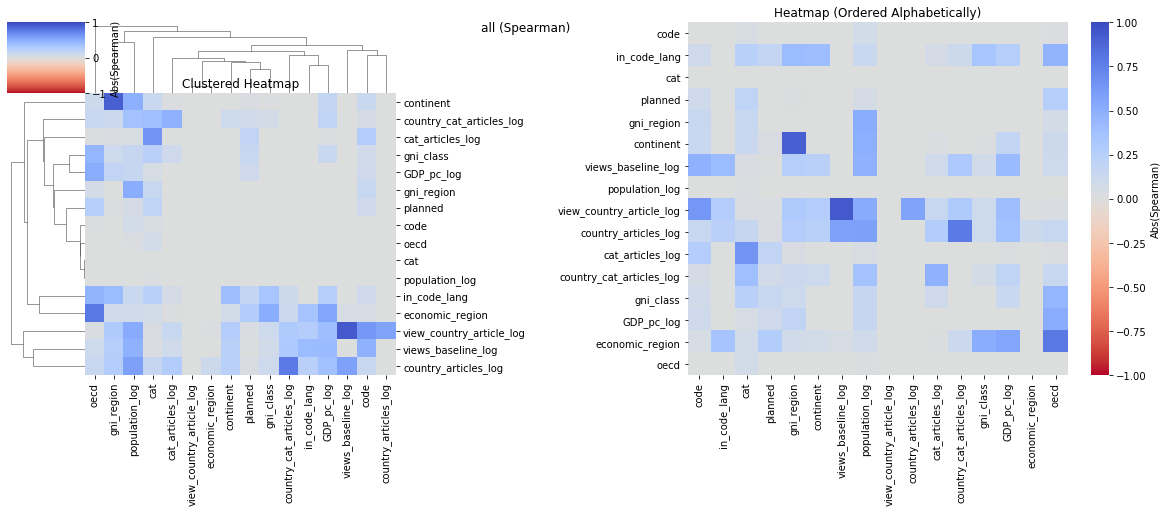

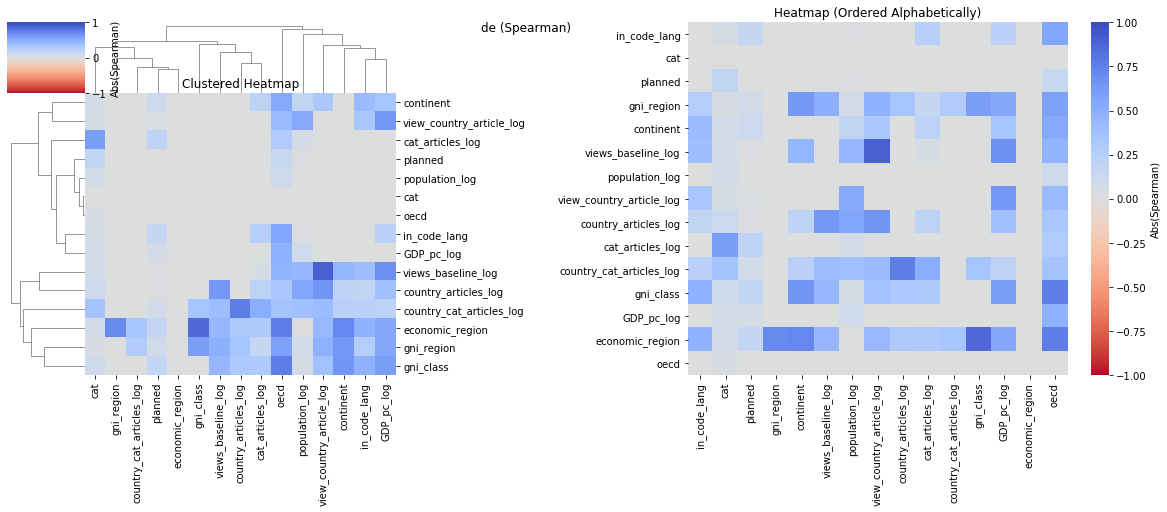

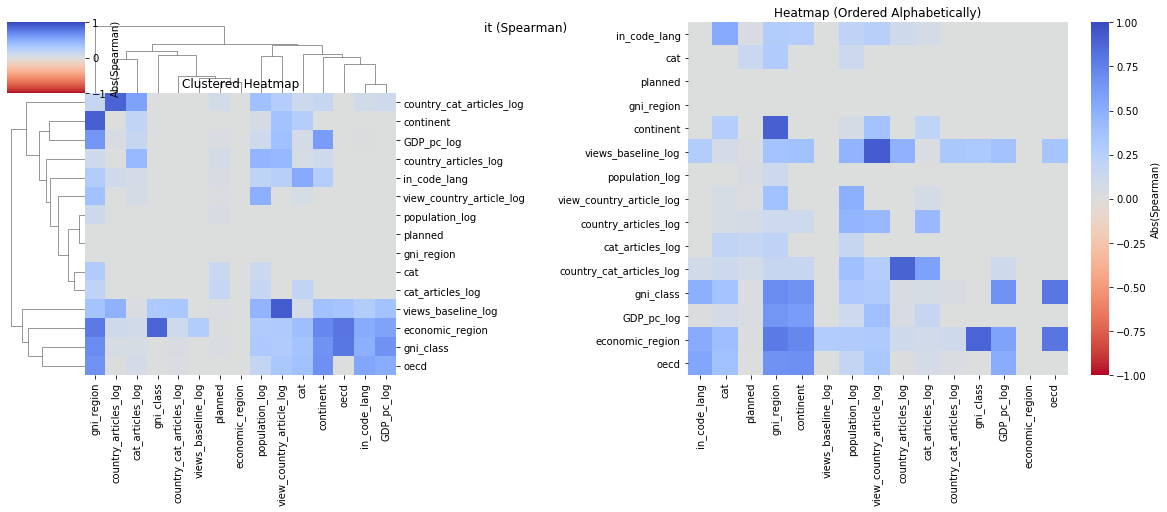

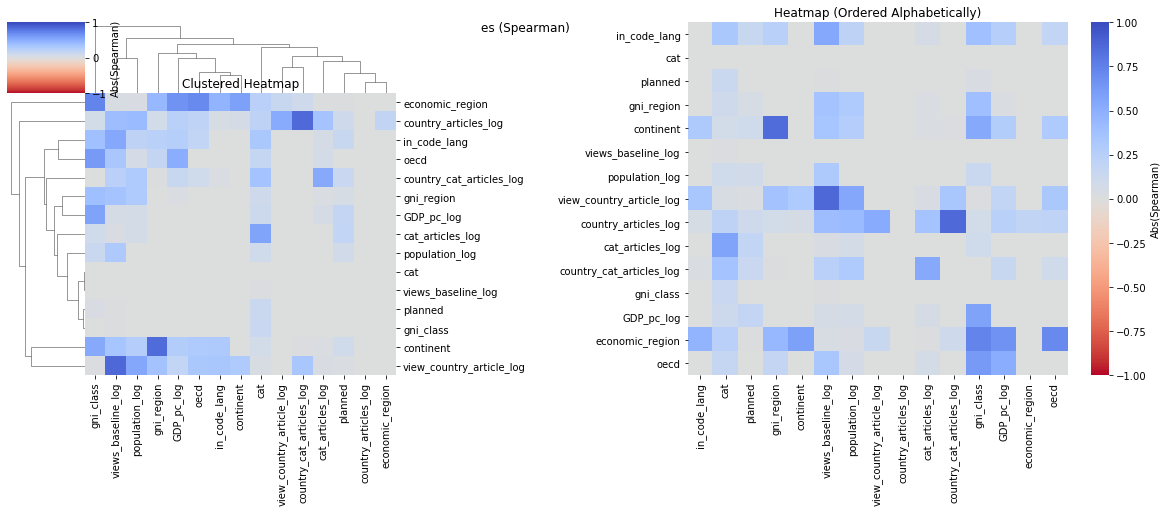

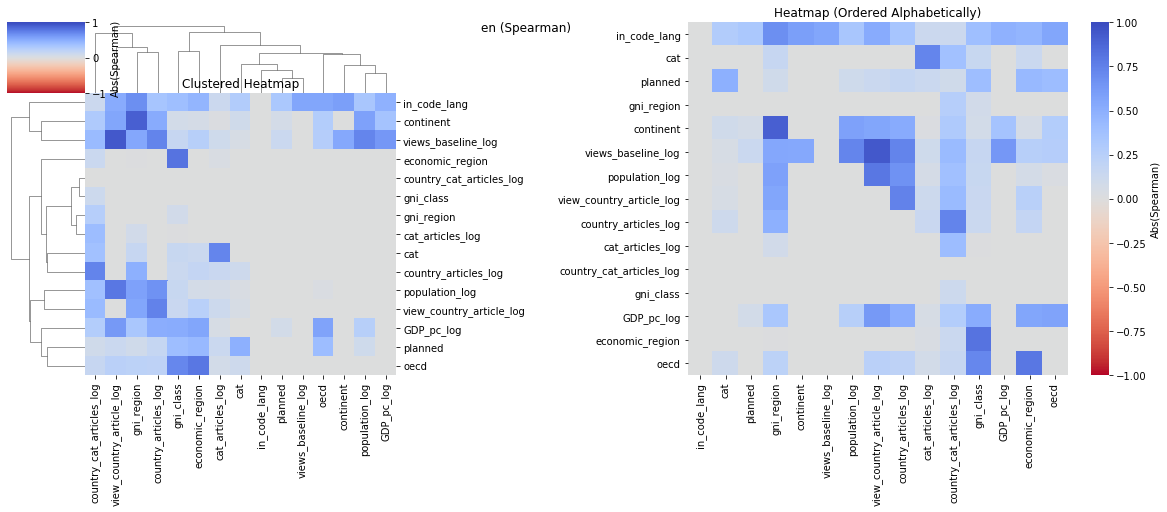

In [542]:
for code in ['all', 'de', 'it',  'es', 'en']:
    fig, corr_matrix = plot_heatmap_and_clustermap(df_reg, list_coefs, corr_matrix=red_matrices_sm[code], suptitle=f'{code} (Spearman)', figsize=(18, 7), cmap_title='Abs(Spearman)')

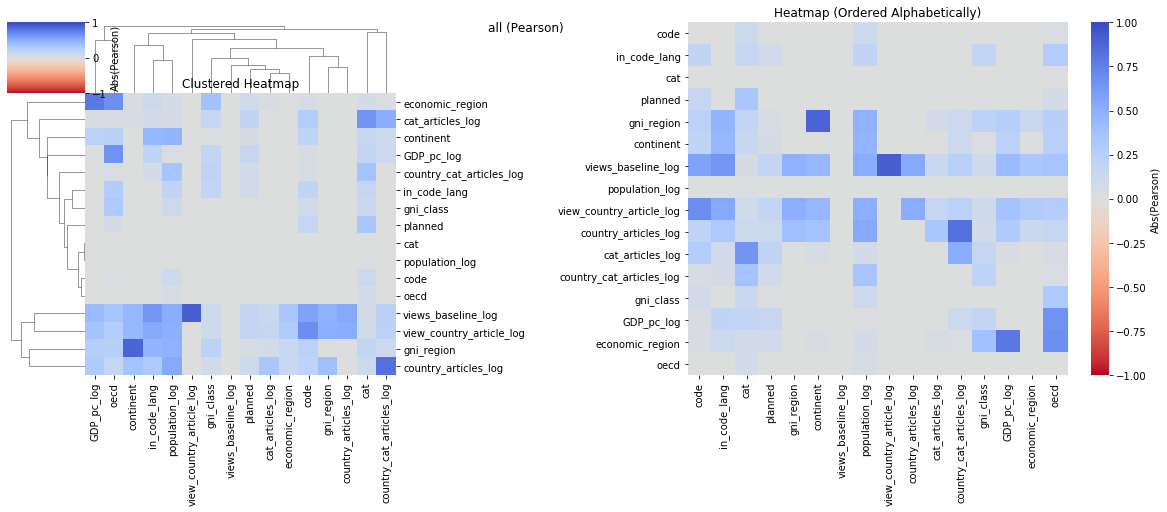

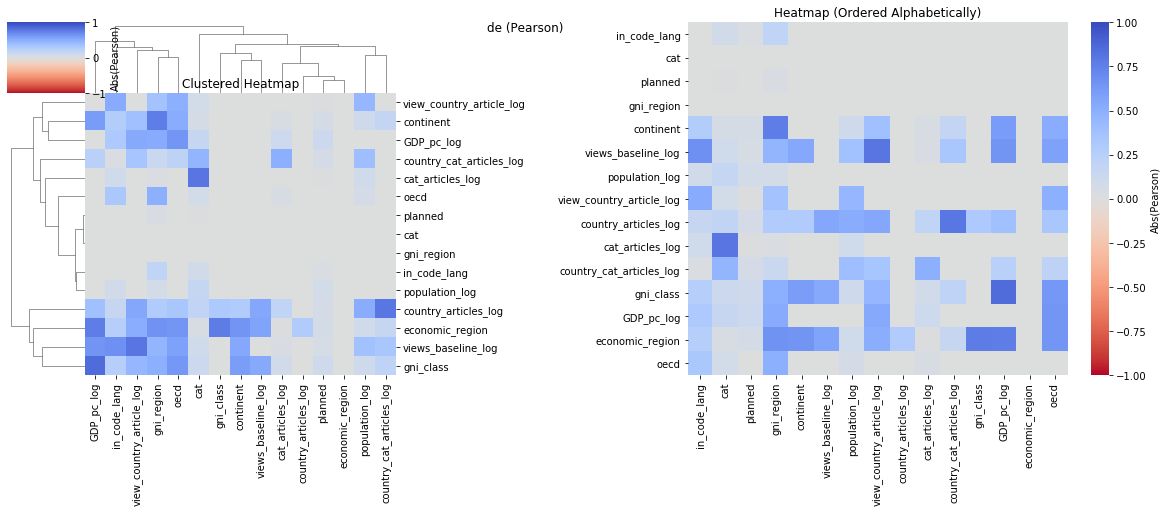

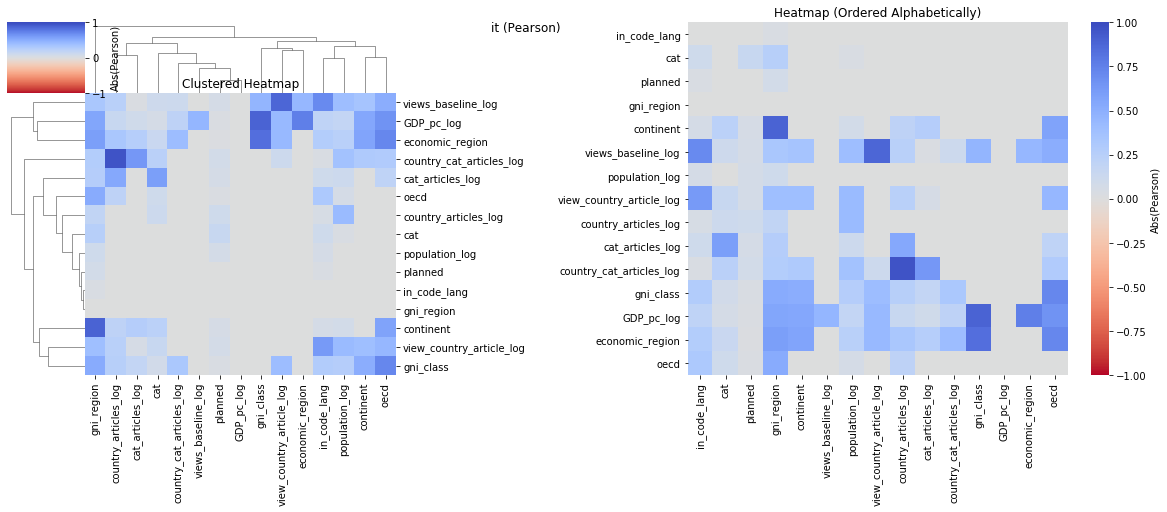

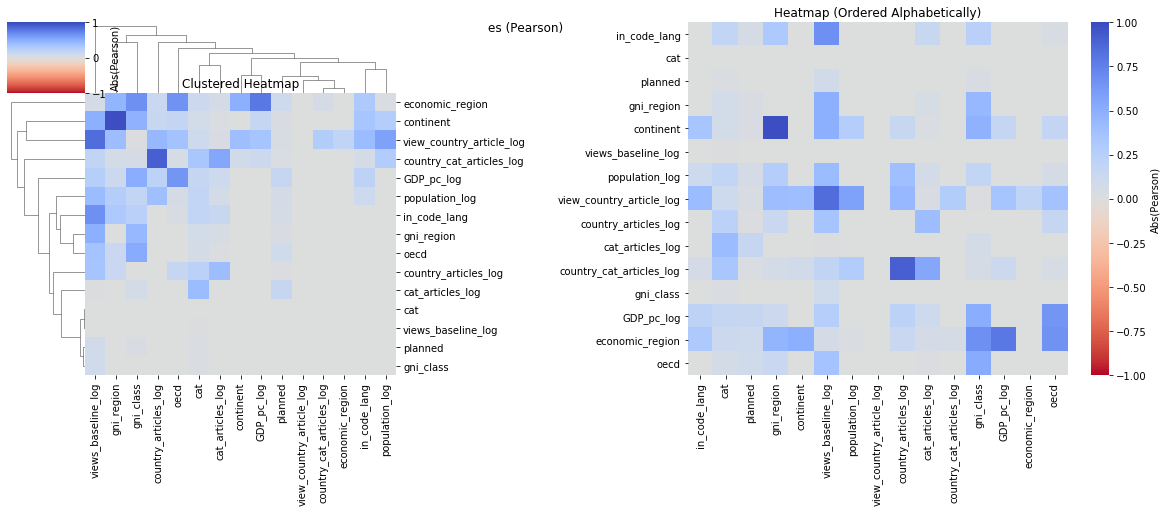

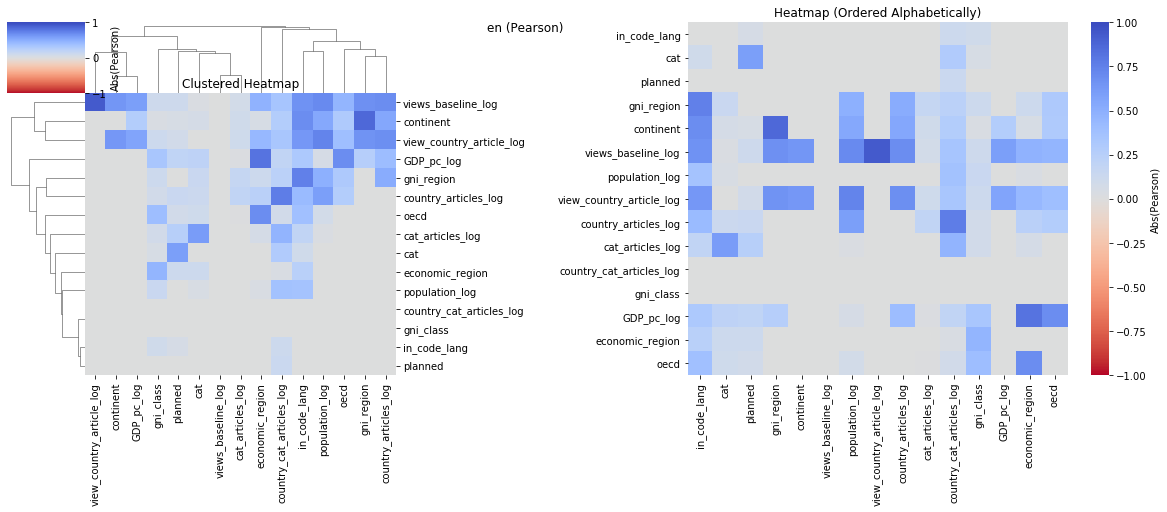

In [543]:
for code in ['all', 'de', 'it', 'es', 'en']:
    fig, corr_matrix = plot_heatmap_and_clustermap(df_reg, list_coefs, corr_matrix=red_matrices[code], suptitle=f'{code} (Pearson)', figsize=(18, 7), cmap_title='Abs(Pearson)')

In [499]:
df_mrmr[('all', 'column')]

0                          cat
1               population_log
2                     GDP_pc_z
3                         code
4                    gni_class
5     country_cat_articles_log
6                         oecd
7                    continent
8             cat_articles_log
9              economic_region
10                  gni_region
11        country_articles_log
12    view_country_article_log
13          views_baseline_log
Name: (all, column), dtype: object

#### feature groups

In [478]:
list_coefs

['code',
 'cat',
 'gni_region',
 'continent',
 'views_baseline_log',
 'population_log',
 'view_country_article_log',
 'country_articles_log',
 'cat_articles_log',
 'country_cat_articles_log',
 'gni_class',
 'GDP_pc_z',
 'economic_region',
 'oecd']

In [482]:
cat_domains = {'geo': ['gni_region', 'continent'], 'eco': ['oecd', 'gni_class', 'GDP_pc_z', 'economic_region'], 
              'views': ['views_baseline_log', 'views_country_article_log'], 'fu': ['cat_articles_log', 'country_articles_log', 'country_cat_articles_log']}

In [489]:
df_mrmr_dom, red_matrices_dom = compute_mrmr_for_code(df_reg, list_coefs, list_coefs_cat, cat_domains=cat_domain, red_func='pearson')
df_mrmr_dom_sm, red_matrices_dom_sm = compute_mrmr_for_code(df_reg, list_coefs, list_coefs_cat, cat_domains=cat_domain, red_func='spearman')

In [500]:
df_mrmr_dom

de                                  en            \
                      column       rel                    column       rel   
0                        cat  3.189857  country_cat_articles_log  1.494964   
1   view_country_article_log  0.863282                       cat  1.117438   
2         views_baseline_log  1.014492                 gni_class  1.022447   
3             population_log  1.345912  view_country_article_log  1.191783   
4                   GDP_pc_z  1.264023        views_baseline_log  1.014556   
5                       oecd  1.364564           economic_region  1.193874   
6                  continent  0.931721                  GDP_pc_z  1.447088   
7                  gni_class  2.082651                      oecd  1.119523   
8       country_articles_log  0.901544                 continent  1.507002   
9            economic_region  0.994829            population_log  1.366736   
10          cat_articles_log  1.156709                gni_region  1.101190   
11                gni_region  0.899328      country_articles_log  1.135667   
12  country_cat_articles_log  1.101588          cat_articles_log  1.093109   
13                       NaN       NaN                       NaN       NaN   

                          es                                  it            \
                      column       rel                    column       rel   
0                        cat  1.394117                gni_region  1.333545   
1                  continent  1.205268                       cat  1.384032   
2                 gni_region  1.229169                 continent  1.266578   
3                       oecd  1.009059                      oecd  0.850917   
4            economic_region  0.833284            population_log  1.077518   
5                   GDP_pc_z  0.984436           economic_region  1.016623   
6         views_baseline_log  0.859827  country_cat_articles_log  1.034263   
7   view_country_article_log  1.099919                  GDP_pc_z  1.224235   
8       country_articles_log  0.841053  view_country_article_log  1.047272   
9             population_log  1.103657        views_baseline_log  1.020043   
10          cat_articles_log  1.064261          cat_articles_log  1.022040   
11                 gni_class  1.071194                 gni_class  1.050024   
12  country_cat_articles_log  1.074139      country_articles_log  1.101422   
13                       NaN       NaN                       NaN       NaN   

                         all            
                      column       rel  
0                        cat  1.293005  
1                 gni_region  1.414355  
2                       code  1.353220  
3       country_articles_log  1.225305  
4                  continent  1.151848  
5   view_country_article_log  0.996945  
6         views_baseline_log  1.175232  
7                   GDP_pc_z  1.230653  
8                       oecd  1.154240  
9            economic_region  1.093868  
10            population_log  1.044167  
11                 gni_class  1.126361  
12          cat_articles_log  1.041269  
13  country_cat_articles_log  1.091063

In [501]:
df_mrmr_dom_sm

de                                  en            \
                      column       rel                    column       rel   
0                        cat  3.189857  country_cat_articles_log  1.494964   
1   view_country_article_log  0.863282                       cat  1.117438   
2         views_baseline_log  1.014492                 gni_class  1.022447   
3             population_log  1.345912  view_country_article_log  1.191783   
4                   GDP_pc_z  1.264023        views_baseline_log  1.014556   
5                       oecd  1.364564           economic_region  1.193874   
6                  continent  0.931721                  GDP_pc_z  1.447088   
7                  gni_class  2.082651                      oecd  1.119523   
8       country_articles_log  0.901544                 continent  1.507002   
9            economic_region  0.994829            population_log  1.366736   
10          cat_articles_log  1.156709                gni_region  1.101190   
11                gni_region  0.899328      country_articles_log  1.135667   
12  country_cat_articles_log  1.101588          cat_articles_log  1.093109   
13                       NaN       NaN                       NaN       NaN   

                          es                                  it            \
                      column       rel                    column       rel   
0                        cat  1.394117                gni_region  1.333545   
1                  continent  1.205268                       cat  1.384032   
2                 gni_region  1.229169                 continent  1.266578   
3                       oecd  1.009059                      oecd  0.850917   
4            economic_region  0.833284            population_log  1.077518   
5                   GDP_pc_z  0.984436           economic_region  1.016623   
6         views_baseline_log  0.859827  country_cat_articles_log  1.034263   
7   view_country_article_log  1.099919                  GDP_pc_z  1.224235   
8       country_articles_log  0.841053  view_country_article_log  1.047272   
9             population_log  1.103657        views_baseline_log  1.020043   
10                 gni_class  1.064261          cat_articles_log  1.022040   
11          cat_articles_log  1.071194                 gni_class  1.050024   
12  country_cat_articles_log  1.074139      country_articles_log  1.101422   
13                       NaN       NaN                       NaN       NaN   

                         all            
                      column       rel  
0                        cat  1.293005  
1                 gni_region  1.414355  
2                       code  1.353220  
3       country_articles_log  1.225305  
4                  continent  1.151848  
5   view_country_article_log  0.996945  
6         views_baseline_log  1.175232  
7                   GDP_pc_z  1.230653  
8                       oecd  1.154240  
9            economic_region  1.093868  
10            population_log  1.044167  
11                 gni_class  1.126361  
12          cat_articles_log  1.041269  
13  country_cat_articles_log  1.091063

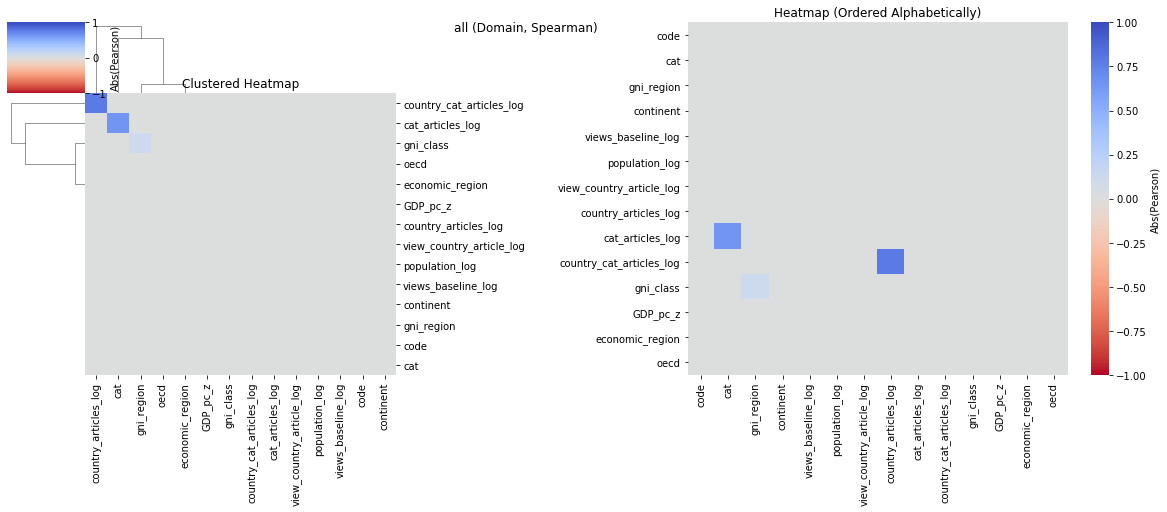

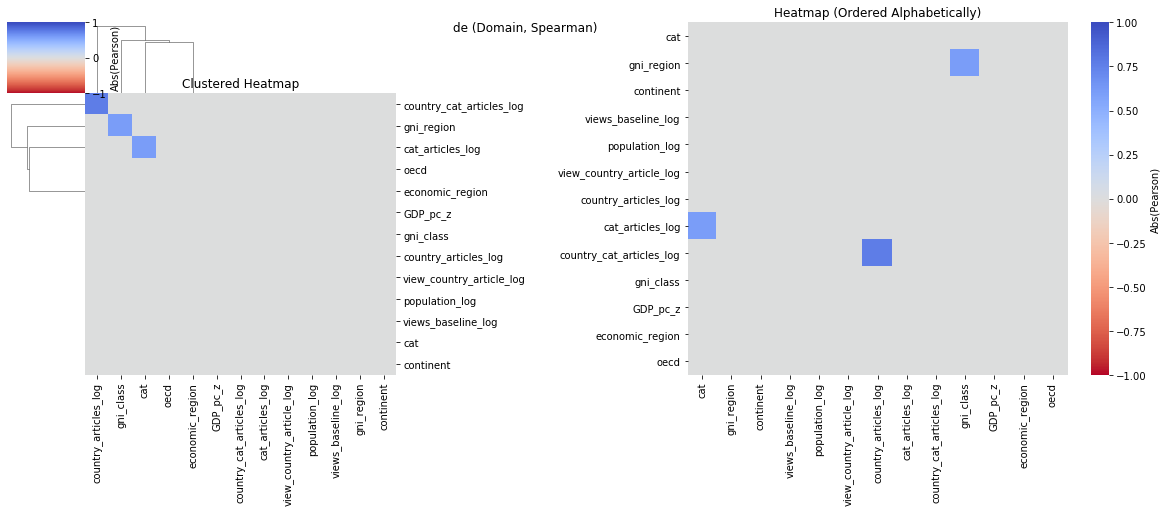

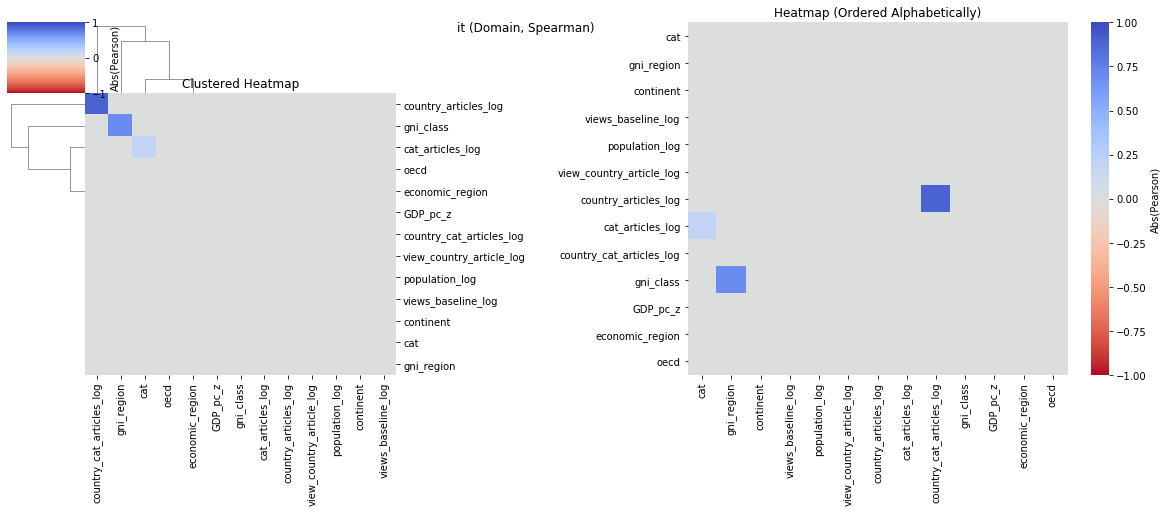

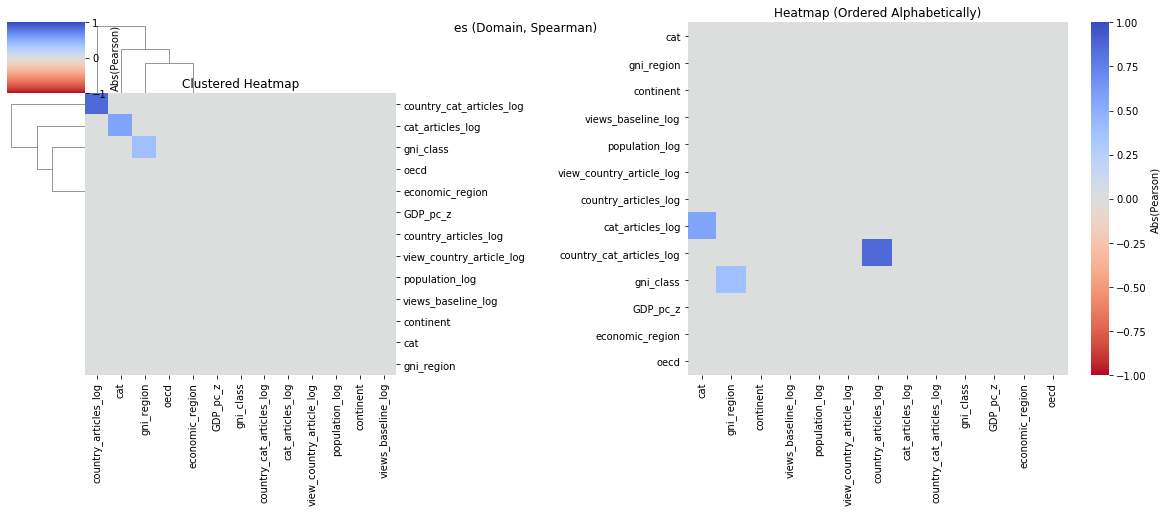

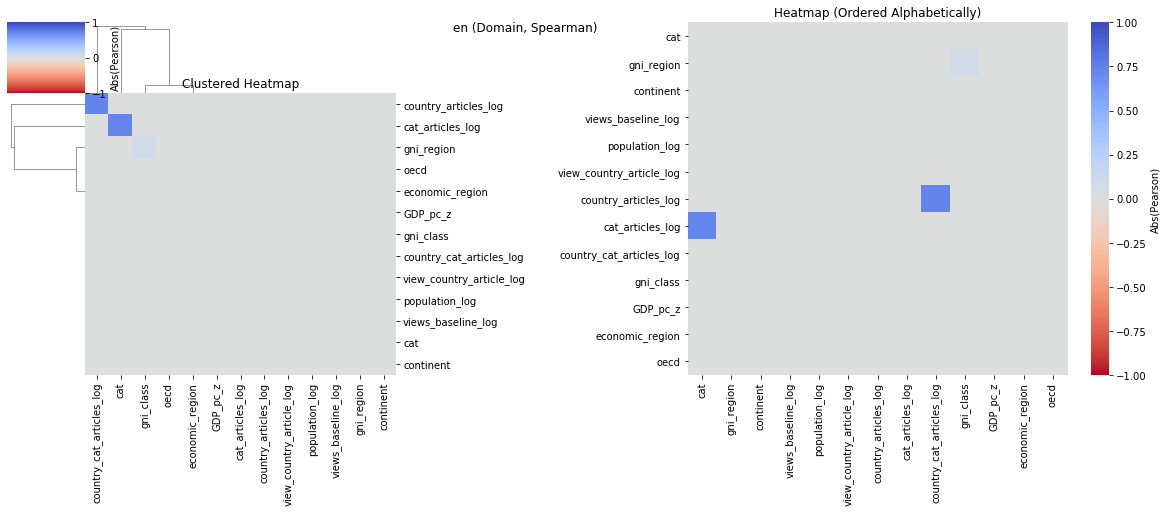

In [498]:
for code in ['all', 'de', 'it', 'es', 'en']:
    fig, corr_matrix = plot_heatmap_and_clustermap(df_reg, list_coefs, corr_matrix=red_matrices_dom_sm[code], suptitle=f'{code} (Domain, Spearman)', figsize=(18, 7), cmap_title='Abs(Pearson)')

# Chi²


In [16]:
from scipy.stats import chi2, kruskal, chisquare, chi2_contingency
import statsmodels.api as sm     
import itertools

In [277]:
def pairwise_mwu_test(df, categories, cat_column, val_column):
    df_test = pd.DataFrame(index=categories, columns=categories)

    for comb1, comb2 in itertools.product(categories, categories):
        df_test[comb1][comb2] = stats.mannwhitneyu(df[df[cat_column] == comb1][val_column], df[df[cat_column] == comb2][val_column]).pvalue
        df_test[comb2][comb1] = df_test[comb1][comb2]
        df_test[comb2][comb2] = 1.0
        df_test[comb1][comb1] = 1.0
    return df_test

def compute_chisq_pairwise(df, cols):
    # h0: x1 ... xn have the same distributions
    # "the distribution of x1 is the same for each x2"
    df_test = pd.DataFrame(index=cols, columns=cols)
    cont_table_dict = {}
    for col1, col2 in itertools.product(cols, cols):
        cont_table_dict[(col1, col2)] = pd.crosstab(df_reg[col1], df_reg[col2])
        df_test.loc[col1, col2] = df_test.loc[col1, col2] = chi2_contingency(cont_table_dict[(col1, col2)])[1]
        df_test.loc[col1, col1] = df_test.loc[col2, col2] = 1.0
    return df_test, cont_table_dict

In [278]:
df_chi, cont_table_dict = compute_chisq_pairwise(df_reg, ['gni_class', 'gni_region', 'continent'])
df_chi

,gni_class,gni_region,continent
gni_class,1.0,0.0,0.0
gni_region,0.0,1.0,0.0
continent,0.0,0.0,1.0


In [280]:
cont_table_dict[('gni_class', 'gni_region')]

gni_region,East Asia & Pacific,Europe & Central Asia,Latin America & Caribbean,Middle East & North Africa,North America,South Asia,Sub-Saharan Africa
gni_class,,,,,,,
H,771,4858,190,204,2554,0,3
L,10,1,4,44,0,46,142
LM,282,113,56,127,0,233,109
UM,537,695,1608,95,0,5,62


In [20]:
cont_table = pd.crosstab(df_reg.continent,  df_reg.gni_region)
cont_table

gni_region,East Asia & Pacific,Europe & Central Asia,Latin America & Caribbean,Middle East & North Africa,North America,South Asia,Sub-Saharan Africa
continent,,,,,,,
Africa,0,0,0,121,0,0,316
Asia,1220,315,0,338,0,284,0
Europe,0,5349,0,11,0,0,0
North America,0,3,349,0,2554,0,0
Oceania,380,0,0,0,0,0,0
South America,0,0,1509,0,0,0,0


### Mutual information

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression

In [23]:
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_regression

In [370]:
def compute_mi(df, coefs, target='views_7_sum'):
    df_dummies = pd.get_dummies(df[coefs])
    mi_result = mutual_info_regression(df_dummies, df[target])
    return sorted(list(zip(df_dummies.columns, np.round(mi_result,3))), key=lambda tup: tup[1], reverse=True)

def compute_mi_for_code(df, coefs, target='views_7_sum'):     
    code_res = []
    for code, df_code in df.groupby('code'):
        code_res.append(pd.DataFrame([[column, val] for column, val in compute_mi(df_code, coefs, target)], columns=[(code, f'column'), (code, f'mi')]))
    code_res.append(pd.DataFrame([[column, val] for column, val in compute_mi(df, coefs, target)], columns=[('all', f'column'), ('all', f'mi')]))   
    df_res = pd.concat(code_res, axis=1)
    df_res.columns = pd.MultiIndex.from_tuples(df_res.columns)
    return df_res

def compute_mi_for_code2(df, coefs, target='views_7_sum'):     
    return {code: compute_mi(df_code, coefs, target) for code, df_code in df.groupby('code')}

In [371]:
dic_codes = compute_mi_for_code(df_reg, list_coefs + ['gni_class_ranked'])

In [267]:
dic_codes

de         \
                                   column    val   
0                        cat_articles_log  0.203   
1                              cat_sports  0.158   
2                          population_log  0.111   
3                country_cat_articles_log  0.076   
4                                GDP_pc_z  0.073   
5                      views_baseline_log  0.070   
6                            cat_politics  0.065   
7                view_country_article_log  0.044   
8                            cat_disaster  0.040   
9                 continent_North America  0.027   
10                            cat_culture  0.019   
11   gni_region_Latin America & Caribbean  0.016   
12                   country_articles_log  0.011   
13               gni_region_North America  0.009   
14                           gni_class_UM  0.008   
15                continent_South America  0.006   
16          gni_region_Sub-Saharan Africa  0.005   
17         gni_region_East Asia & Pacific  0.004   
18                       continent_Europe  0.004   
19                       gni_class_ranked  0.003   
20  gni_region_Middle East & North Africa  0.003   
21                      continent_Oceania  0.003   
22                                   oecd  0.000   
23                                code_de  0.000   
24       gni_region_Europe & Central Asia  0.000   
25                  gni_region_South Asia  0.000   
26                       continent_Africa  0.000   
27                         continent_Asia  0.000   
28                            gni_class_H  0.000   
29                            gni_class_L  0.000   
30                           gni_class_LM  0.000   
31           economic_region_Global North  0.000   
32           economic_region_Global South  0.000   
33                                    NaN    NaN   
34                                    NaN    NaN   
35                                    NaN    NaN   

                                       en         \
                                   column    val   
0                          population_log  0.136   
1                      views_baseline_log  0.132   
2                view_country_article_log  0.132   
3                                GDP_pc_z  0.122   
4                        cat_articles_log  0.083   
5                    country_articles_log  0.063   
6                country_cat_articles_log  0.059   
7                              cat_sports  0.020   
8                        continent_Europe  0.017   
9        gni_region_Europe & Central Asia  0.014   
10                           cat_politics  0.011   
11                           gni_class_UM  0.011   
12   gni_region_Latin America & Caribbean  0.010   
13                           cat_disaster  0.009   
14                continent_South America  0.009   
15                       gni_class_ranked  0.006   
16          gni_region_Sub-Saharan Africa  0.005   
17         gni_region_East Asia & Pacific  0.004   
18               gni_region_North America  0.003   
19                      continent_Oceania  0.003   
20                         continent_Asia  0.001   
21                continent_North America  0.001   
22                            gni_class_H  0.001   
23                            gni_class_L  0.001   
24                                   oecd  0.000   
25                                code_en  0.000   
26                            cat_culture  0.000   
27  gni_region_Middle East & North Africa  0.000   
28                  gni_region_South Asia  0.000   
29                       continent_Africa  0.000   
30                           gni_class_LM  0.000   
31           economic_region_Global North  0.000   
32           economic_region_Global South  0.000   
33                                    NaN    NaN   
34                                    NaN    NaN   
35                                    NaN    NaN   

                                       es         \
                                 

## Pearson

In [ ]:
def compute_pearson(df, coefs, target='views_7_sum'):
    df_dummies = pd.get_dummies(df[coefs])
    mi_result = df_dummies.corr()
    return sorted(list(zip(df_dummies.columns, np.round(mi_result,3))), key=lambda tup: tup[1], reverse=True)

def compute_mi_for_code(df, coefs, target='views_7_sum'):     
    code_res = []
    for code, df_code in df.groupby('code'):
        code_res.append(pd.DataFrame([[column, val] for column, val in compute_mi(df_code, coefs, target)], columns=[(code, f'column'), (code, f'val')]))
    code_res.append(pd.DataFrame([[column, val] for column, val in compute_mi(df, coefs, target)], columns=[('all', f'column'), ('all', f'val')]))   
    df_res = pd.concat(code_res, axis=1)
    df_res.columns = pd.MultiIndex.from_tuples(df_res.columns)
    return df_res

def compute_mi_for_code2(df, coefs, target='views_7_sum'):     
    return {code: compute_mi(df_code, coefs, target) for code, df_code in df.groupby('code')}

# HeatMap

In [85]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import seaborn as sns

In [99]:
df_dummies = df_binary.copy()
df_dummies.columns = df_dummies.columns.str.lower()
df_dummies = df_dummies[sorted(df_dummies.columns)]
corr_dummies = df_dummies.corr('spearman')
corr_dummies_pearson = df_dummies.corr('pearson')

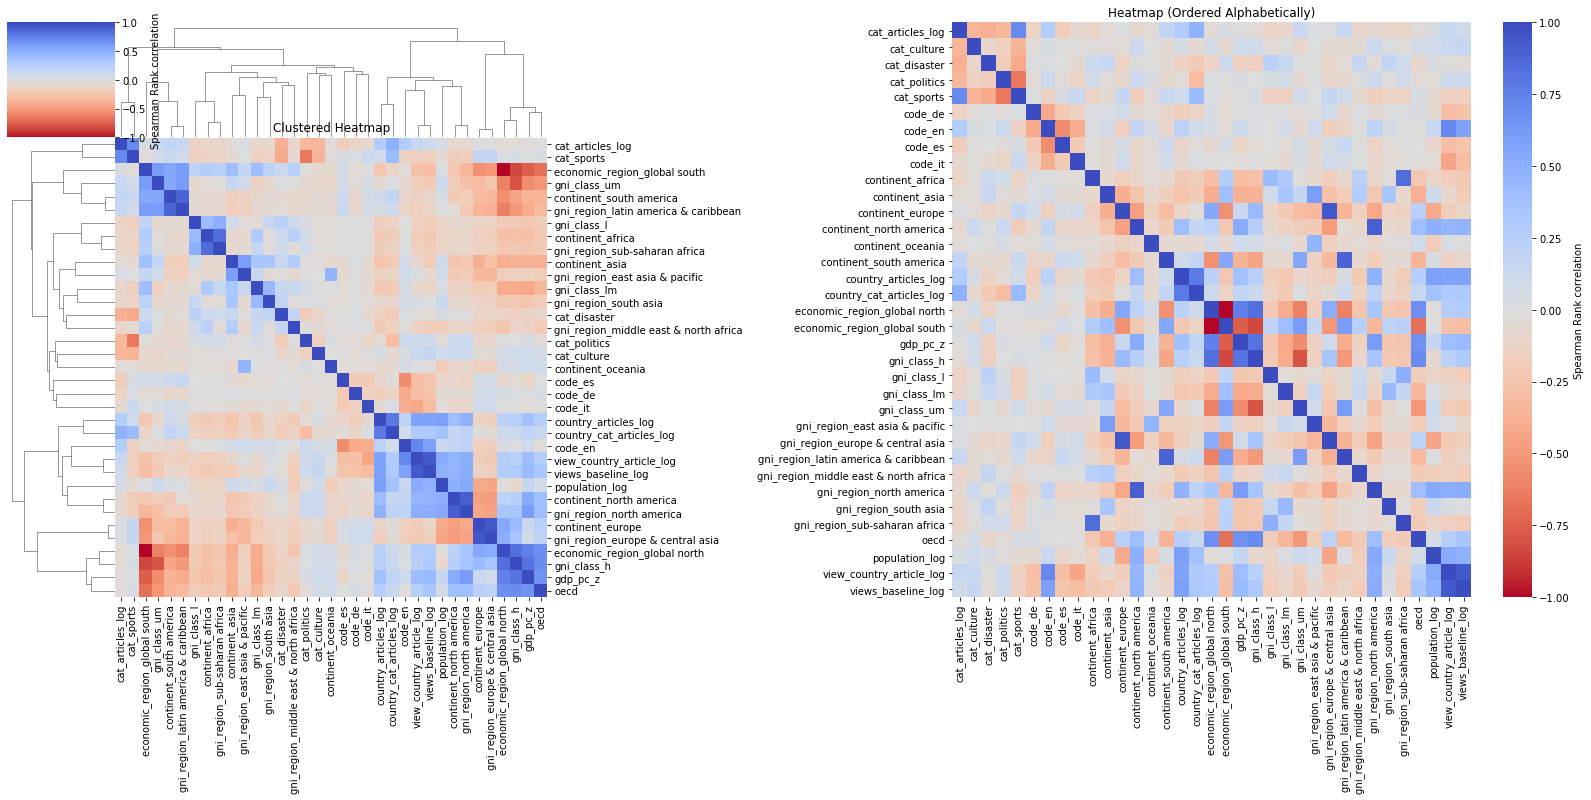

In [441]:
fig_heatmap, corr_matrix = plot_heatmap_and_clustermap(df_reg, list_coefs)
fig_heatmap.savefig(f'figures/corr.pdf', bbox_inches='tight')

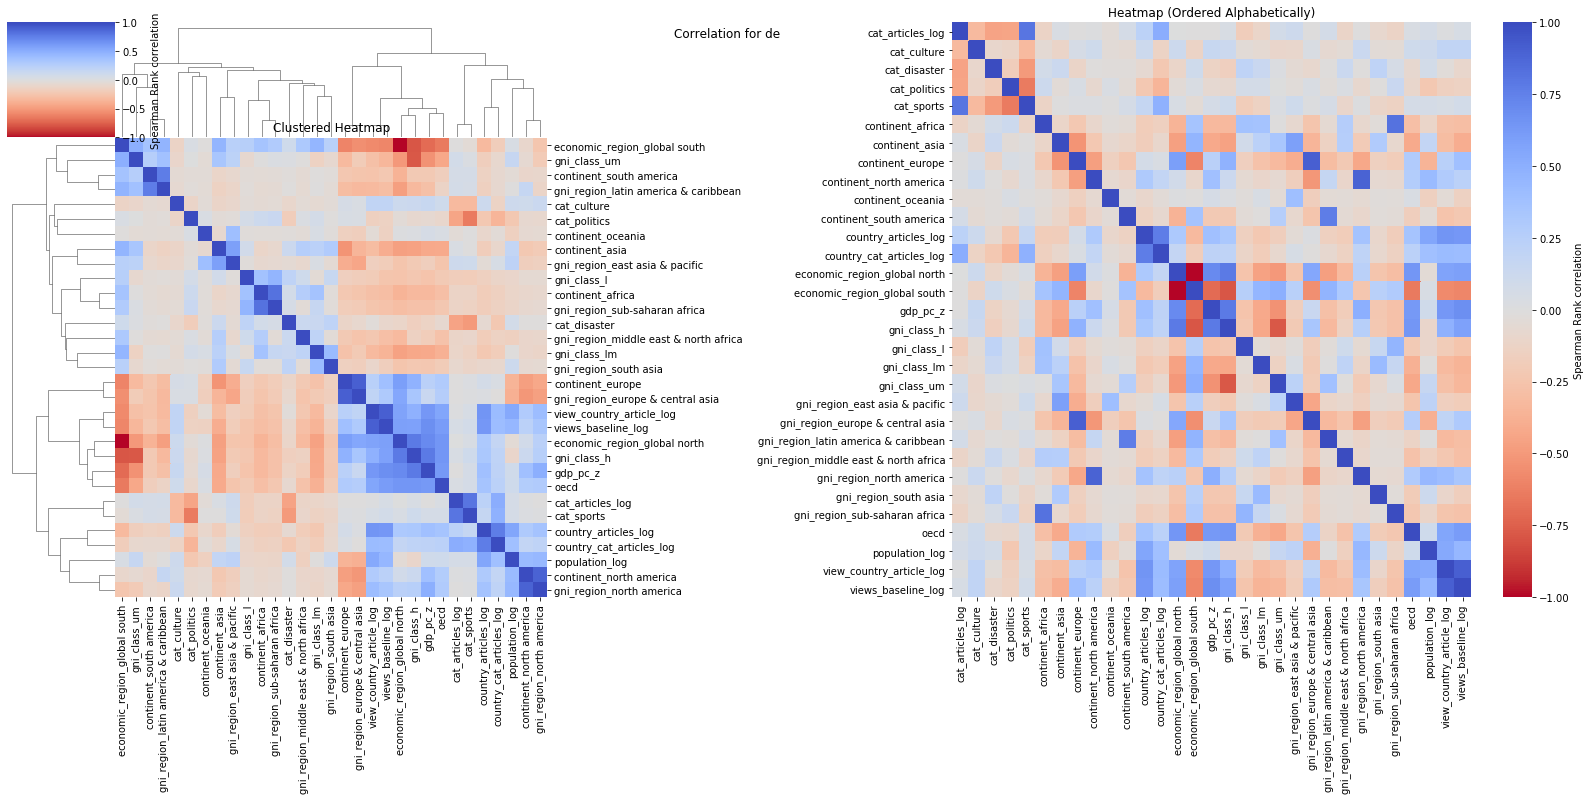

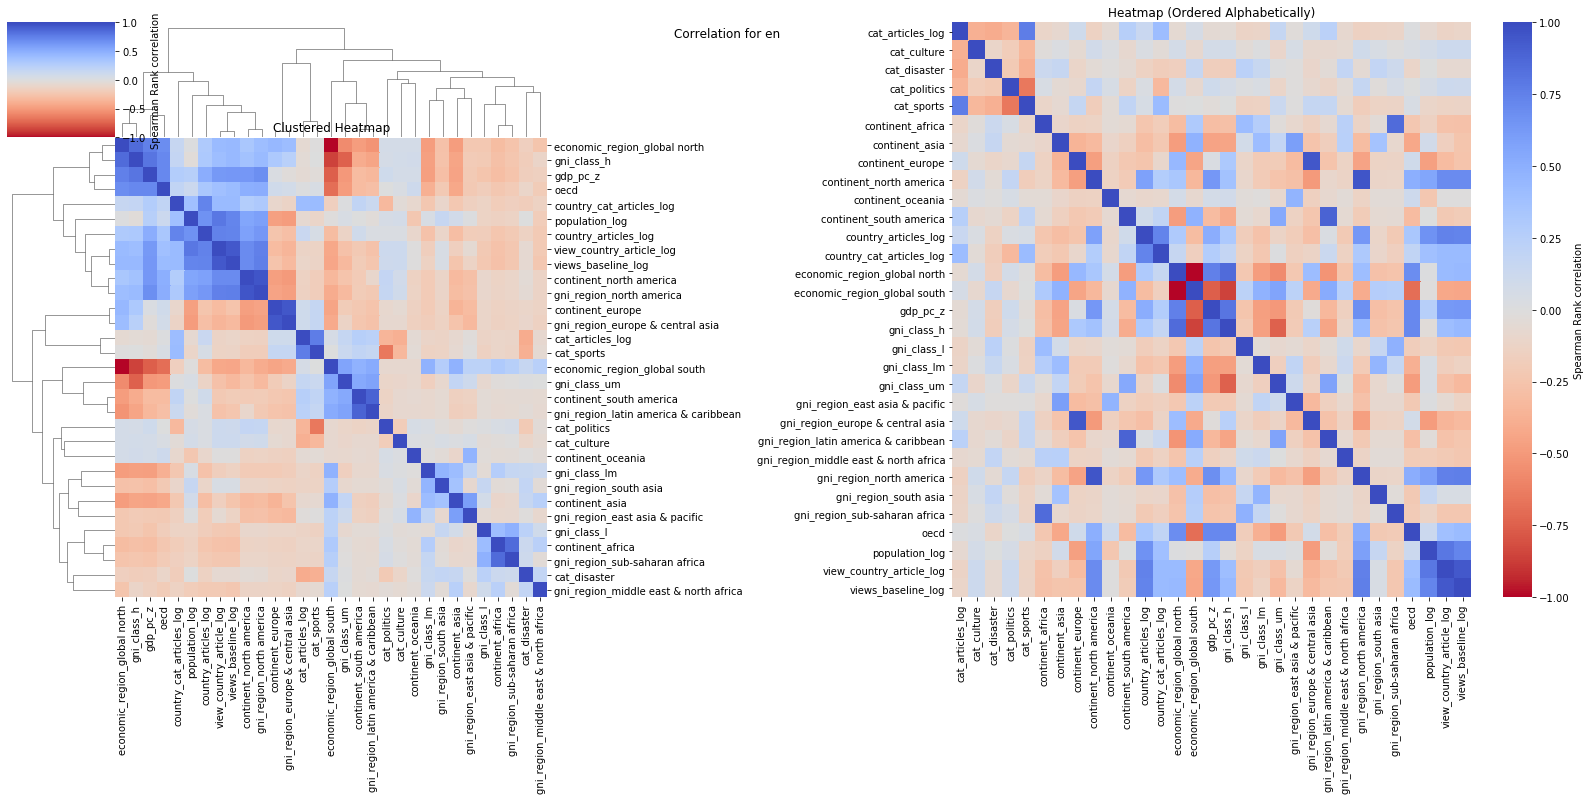

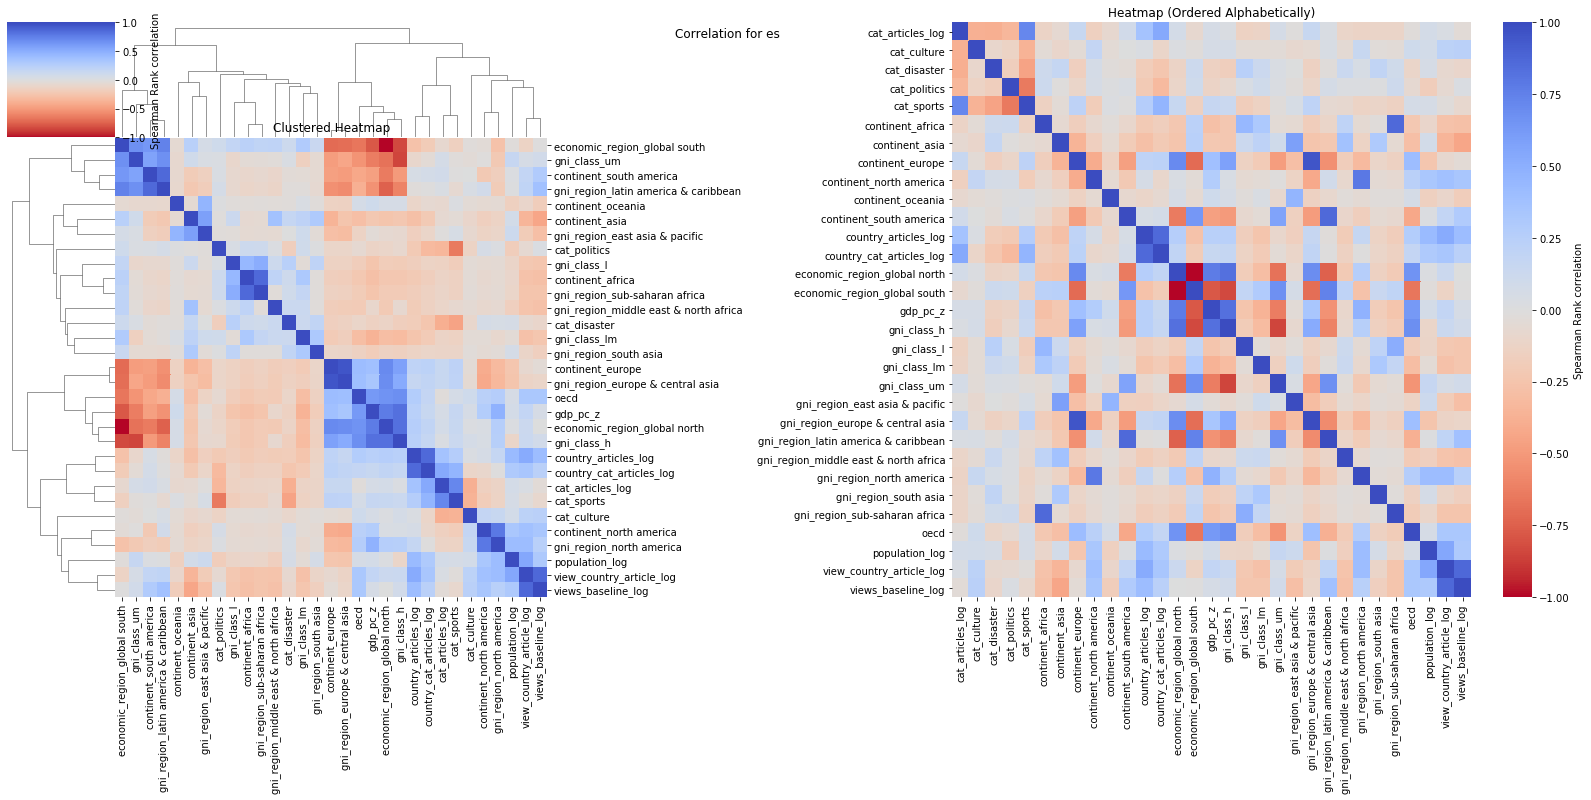

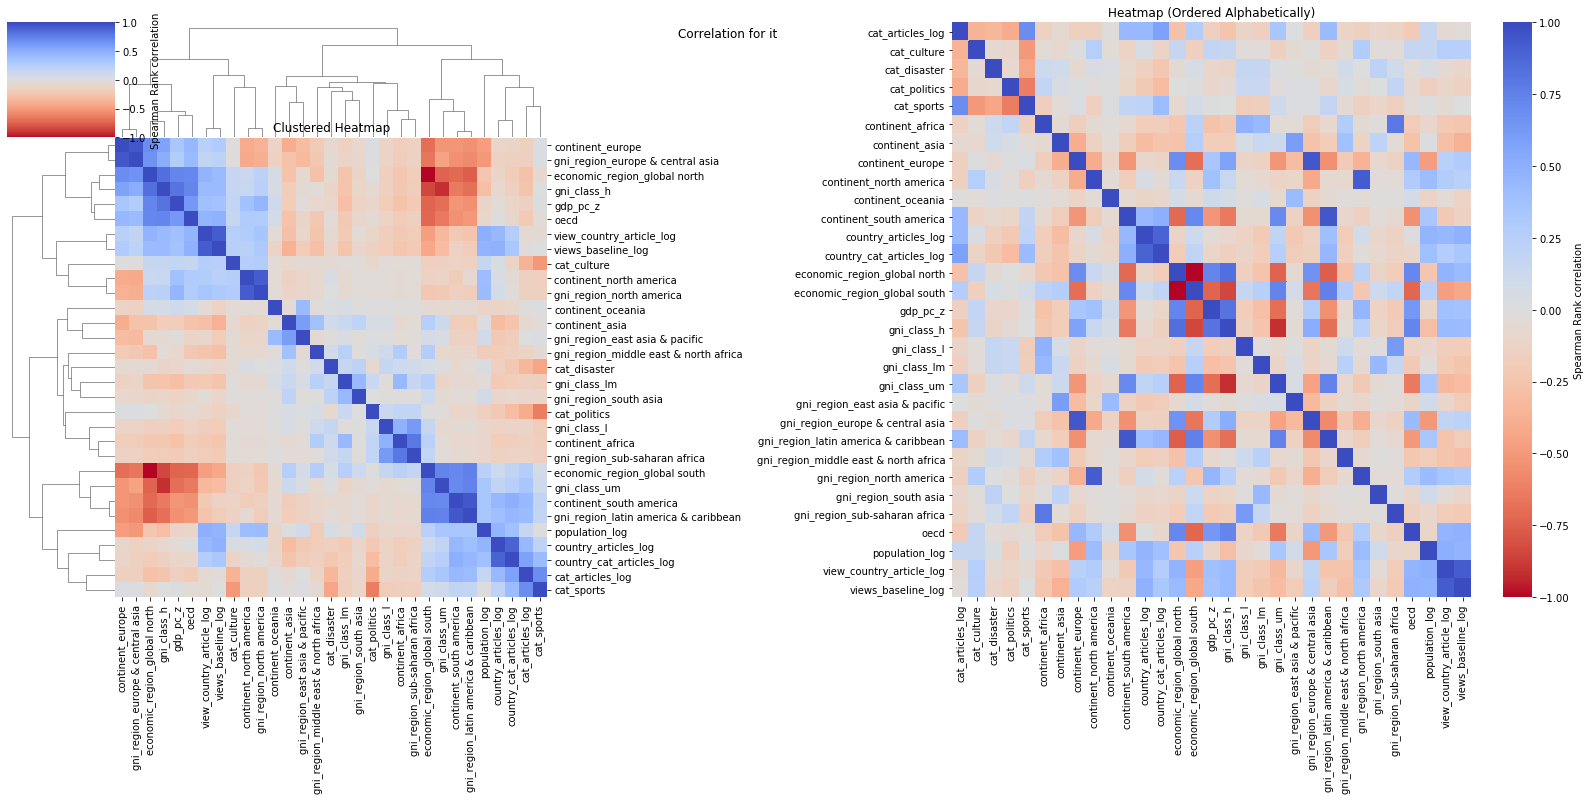

In [443]:
for code, df in df_reg.groupby('code'):
    df_dummies = pd.get_dummies(df[list_coefs])
    df_dummies.columns = df_dummies.columns.str.lower()
    df_dummies = df_dummies[sorted(col for col in df_dummies.columns if not col.startswith('code_'))]
    corr_dummies = df_dummies.corr('spearman')
    fig, corr_matrix = plot_heatmap_and_clustermap(df, list_coefs, suptitle=f'Correlation for {code}', corr_matrix=corr_dummies, figsize=(25,11))
    fig.savefig(f'figures/corr_{code}.pdf', bbox_inches='tight')
    #hm = sns.heatmap(corr_dummies,cmap="coolwarm_r", cbar_kws={'label': 'Spearman Rank correlation'})
    #cm = sns.clustermap(corr_dummies,figsize=(27,11), cmap="coolwarm_r", cbar_kws={'label': 'Spearman Rank correlation'})

## heatmaps

In [458]:
coefs_reduced = [e for e in list_coefs if e not in ['continent', 'view_country_article_log', 'country_cat_articles_log', 'economic_region', 'gni_region']]
coefs_reduced.append('gni_class_ranked')
df_reg['gni_class_ranked'] = df_reg['gni_class'].apply(lambda c: 0 if c=='L' else 1 if c=='LM' else 2 if c=='UM' else 3)

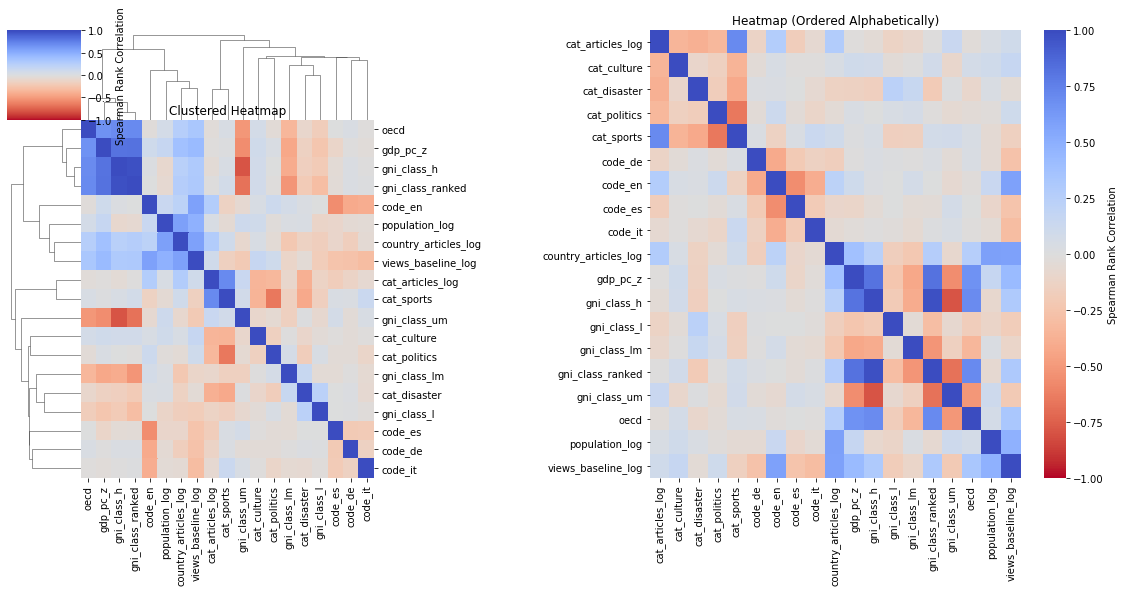

In [459]:
fig_heatmap, df_corr = plot_heatmap_and_clustermap(df_reg, coefs_reduced, figsize=(17,8))
fig_heatmap.savefig(f'figures/corr_red.pdf', bbox_inches='tight')

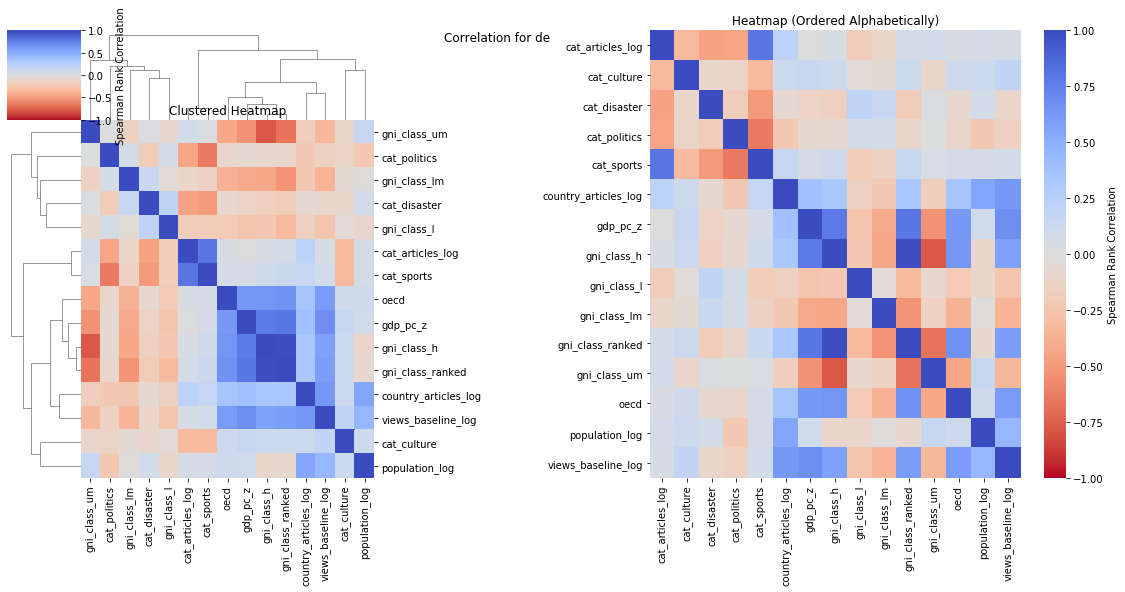

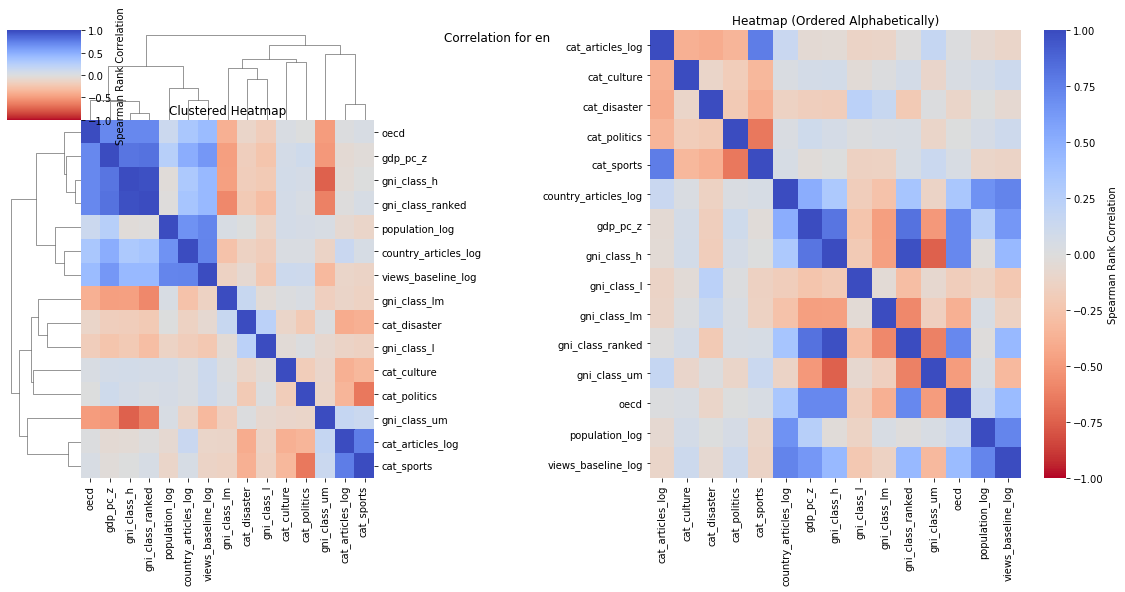

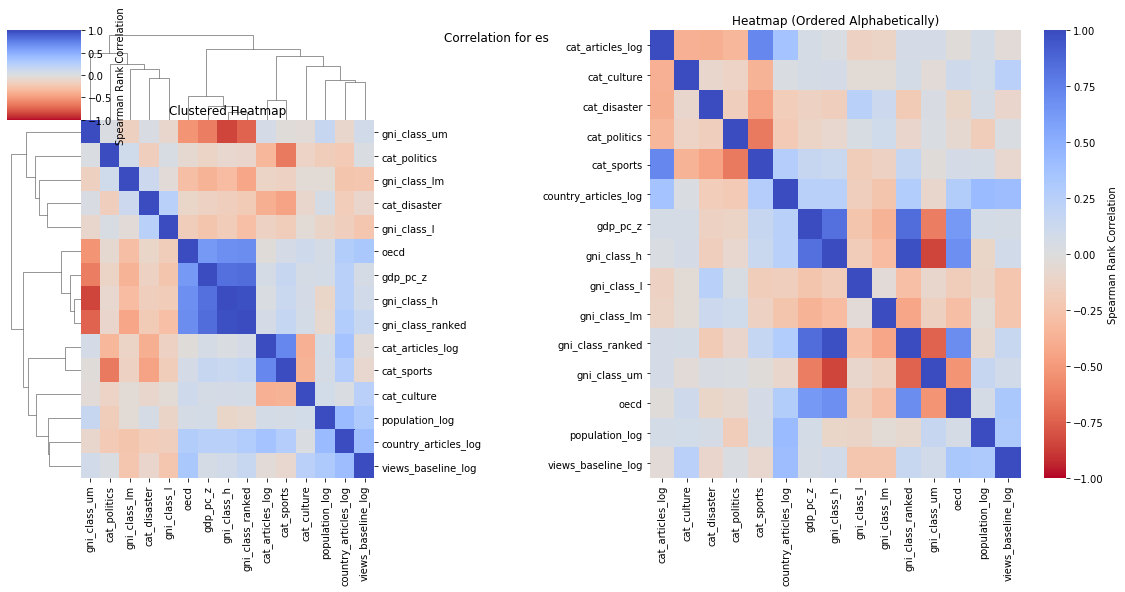

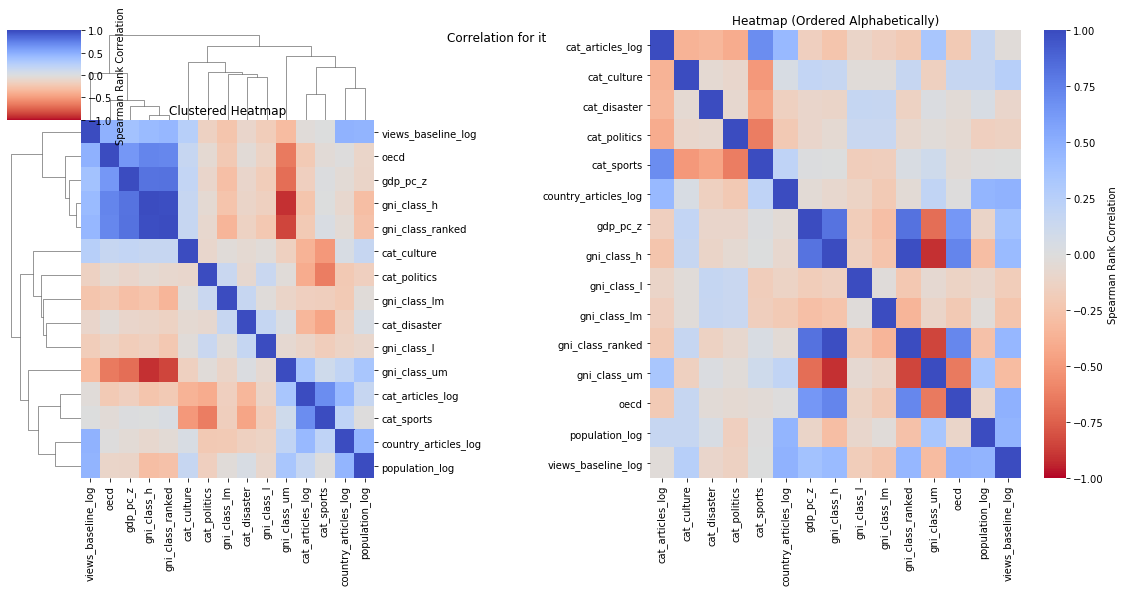

In [460]:
for code, df in df_reg.groupby('code'):
    df_dummies = pd.get_dummies(df[coefs_reduced])
    df_dummies.columns = df_dummies.columns.str.lower()
    df_dummies = df_dummies[sorted(col for col in df_dummies.columns if not col.startswith('code_'))]
    corr_dummies = df_dummies.corr('spearman')
    fig, df_corr = plot_heatmap_and_clustermap(df, coefs_reduced, suptitle=f'Correlation for {code}', corr_matrix=corr_dummies, figsize=(17,8))
    fig.savefig(f'figures/corr_{code}_red.pdf', bbox_inches='tight')